In [3]:
import sys; sys.path.append("..") 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utility import loadfile, savefile, exists
from src.dataprocessing import *
from src import rnn

## load data

In [4]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-5", "LT-3061-2"]
process_var = input_var + output_var

In [5]:
min_len = 100
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(f"{continuous_path}/cts_{min_len}/dataset {min_len}_{i}.csv"):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv', print_msg=False)
    cts_list.append(cts_df)
    i += 1

In [6]:
update = False

# Seq2Seq layer

In [8]:
target_list = cts_list

# history size and future size
history_size = 40
future_size = 10
step = 1

# variable selection
history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

# data to series
history_series = []
future_series = []
for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)
        
# supervised attention factor
delta = 1.5
att_type = 'exp'
factor = rnn.super_attention(delta, future_size, future_num, att_type)
        
# test data split        
test_size = 0.2
test_num = -1

# model structure
num_layers_list = [1, 2]
num_neurons_list = [20, 40, 60]
dense_layers = 1
dense_neurons = 40
model_list = ['seq2seq_gru', 'att_seq2seq_gru', 'datt_seq2seq_gru']

iteration_list = [x for x in range(1,7)]
i=0
for iteration in iteration_list:
    for num_layers in num_layers_list:
        for num_neurons in num_neurons_list:
            for model_type in model_list: 
                model_num = iteration
                model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
                result = loadfile('./result', model_name, file_type='csv', header=1, print_msg=False)
                result.columns = ['R2_TT-3061-3', 'R2_TT-3061-5', 'R2_LT-3061-2', 'R2_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2', 'NRMSE_MEAN']
                time_steps = pd.DataFrame([f't+{i+1}' for i in range(future_size)]+['mean'], columns=['step'])
                result = pd.concat([result, time_steps], axis=1)
                result['iteration'] = iteration
                result['num_layers'] = num_layers
                result['num_neurons'] = num_neurons
                result['model_type'] = model_type
                if not i:
                    result_reshape = result
                else:
                    result_reshape = pd.concat([result_reshape, result], axis=0)
                i += 1

In [9]:
result_reshape[(result_reshape['step']=='mean')&(result_reshape['R2_MEAN']>0.7)].sort_values(by='R2_MEAN', ascending=False)

,R2_TT-3061-3,R2_TT-3061-5,R2_LT-3061-2,R2_MEAN,NRMSE_TT-3061-3,NRMSE_TT-3061-5,NRMSE_LT-3061-2,NRMSE_MEAN,step,iteration,num_layers,num_neurons,model_type
10,0.656641,0.785598,0.875998,0.772746,8.638037,7.993858,5.284619,7.305505,mean,6,1,20,datt_seq2seq_gru
10,0.601842,0.825408,0.879692,0.768981,9.299390,7.204827,5.199344,7.234520,mean,1,1,20,datt_seq2seq_gru
10,0.637962,0.770072,0.893108,0.767047,8.822298,8.311986,4.921822,7.352035,mean,2,1,20,datt_seq2seq_gru
10,0.626860,0.789656,0.862790,0.759769,9.103696,7.949752,5.570275,7.541241,mean,4,1,20,datt_seq2seq_gru
10,0.615464,0.774102,0.884485,0.758017,9.197250,8.169690,5.136523,7.501154,mean,5,2,20,datt_seq2seq_gru
10,0.599628,0.785667,0.867045,0.750780,9.337877,8.028029,5.486701,7.617536,mean,1,2,40,datt_seq2seq_gru
10,0.646079,0.775213,0.830770,0.750687,8.771818,8.095686,6.153194,7.673566,mean,3,1,20,datt_seq2seq_gru
10,0.598507,0.778795,0.868476,0.748593,9.326918,8.174796,5.455579,7.652431,mean,3,2,20,datt_seq2seq_gru
10,0.605376,0.783425,0.854828,0.747877,9.252046,8.062718,5.757157,7.690640,mean,6,2,20,datt_seq2seq_gru
10,0.614848,0.772886,0.849164,0.745632,9.151631,8.217968,5.868514,7.746038,mean,2,1,20,att_seq2seq_gru


## Figure 1

R2 results


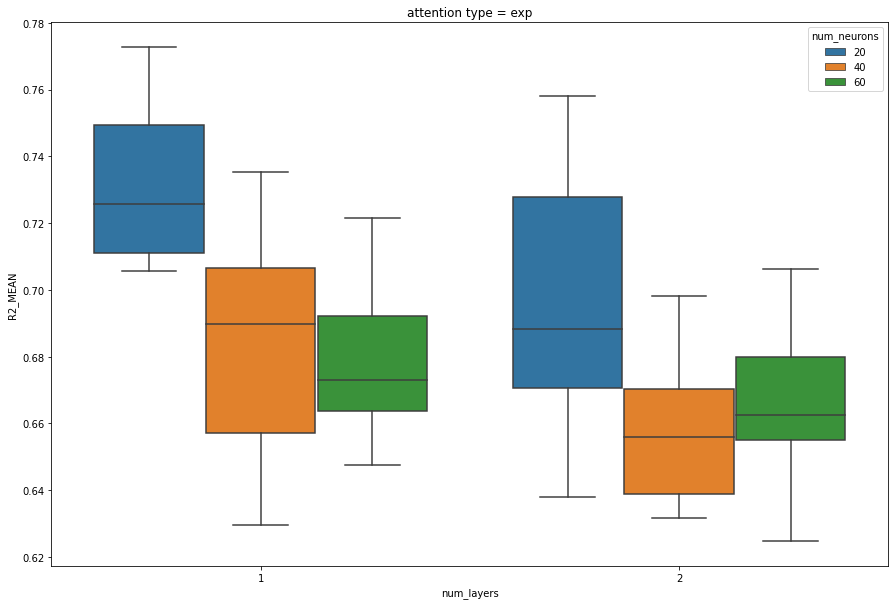

<Figure size 432x288 with 0 Axes>

In [10]:
data = result_reshape

plot_var = ['R2_MEAN']

print("R2 results")
plt.figure(figsize=(15*len(plot_var), 10))
for i, var in enumerate(plot_var):
    plt.subplot(len(plot_var), 1, i+1)
    plot_data = data[data['step']=='mean']
    sns.boxplot(x='num_layers', y=var, hue='num_neurons', data=plot_data, notch=False, showfliers = False)
    # plt.ylim(-0.01, 0.3)
    plt.title(f"attention type = {att_type}")
    
figure_name = f'layer_neuron_comparison_future_{future_size}_DA_seq2seq_r2'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()

## Figure 2

R2 results


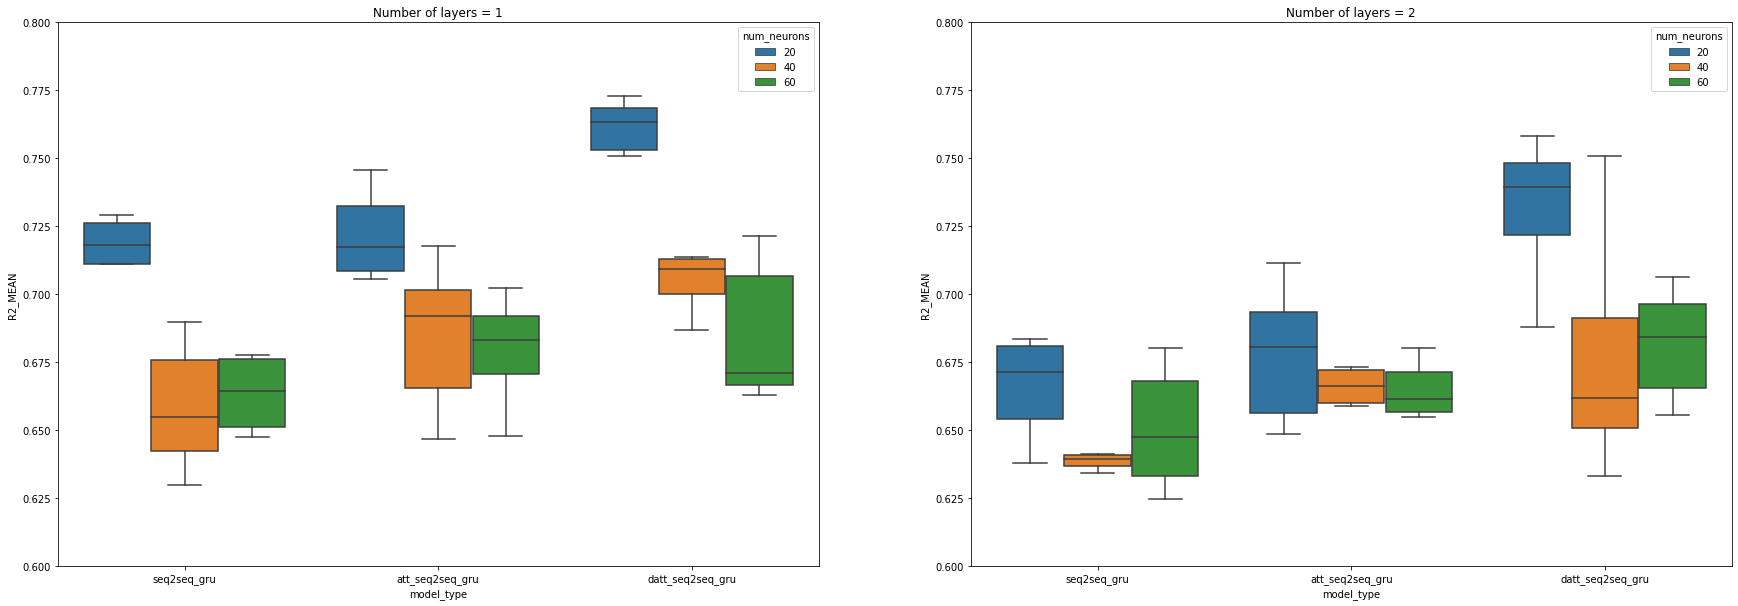

<Figure size 432x288 with 0 Axes>

In [11]:
data = result_reshape

plot_var = [1, 2]

print("R2 results")
plt.figure(figsize=(15*len(plot_var), 10))
for i, num_layers in enumerate(plot_var):
    plt.subplot(1, len(plot_var), i+1)
    plot_data = data[(data['step']=='mean') & (data['num_layers']==num_layers)]
    sns.boxplot(x='model_type', y='R2_MEAN', hue='num_neurons', data=plot_data, notch=False, showfliers = False)
    plt.ylim(0.6, 0.8)
    plt.title(f"Number of layers = {num_layers}")
    
figure_name = f'layer_neuron_model_comparison_future_{future_size}_r2'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()

# Dense layer

In [12]:
target_list = cts_list

# history size and future size
history_size = 40
future_size = 10
step = 1

# variable selection
history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

# data to series
history_series = []
future_series = []
for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)
        
# supervised attention factor
delta = 1.5
att_type = 'exp'
factor = rnn.super_attention(delta, future_size, future_num, att_type)
        
# test data split        
test_size = 0.2
test_num = -1

# model structure
num_layers = 1
num_neurons = 20
dense_layers_list = [1, 2]
dense_neurons_list = [20, 40, 60]
model_list = ['seq2seq_gru', 'att_seq2seq_gru', 'datt_seq2seq_gru']

iteration_list = [x for x in range(1,7)]
i=0
for iteration in iteration_list:
    for dense_layers in dense_layers_list:
        for dense_neurons in dense_neurons_list:
            for model_type in model_list: 
                model_num = iteration
                model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
                result = loadfile('./result', model_name, file_type='csv', header=1, print_msg=False)
                result.columns = ['R2_TT-3061-3', 'R2_TT-3061-5', 'R2_LT-3061-2', 'R2_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2', 'NRMSE_MEAN']
                time_steps = pd.DataFrame([f't+{i+1}' for i in range(future_size)]+['mean'], columns=['step'])
                result = pd.concat([result, time_steps], axis=1)
                result['iteration'] = iteration
                result['dense_layers'] = dense_layers
                result['dense_neurons'] = dense_neurons
                result['model_type'] = model_type
                if not i:
                    result_reshape = result
                else:
                    result_reshape = pd.concat([result_reshape, result], axis=0)
                i += 1

In [13]:
result_reshape[(result_reshape['step']=='mean')&(result_reshape['R2_MEAN']>0.7)].sort_values(by='R2_MEAN', ascending=False)

,R2_TT-3061-3,R2_TT-3061-5,R2_LT-3061-2,R2_MEAN,NRMSE_TT-3061-3,NRMSE_TT-3061-5,NRMSE_LT-3061-2,NRMSE_MEAN,step,iteration,dense_layers,dense_neurons,model_type
10,0.688608,0.835689,0.895239,0.806512,8.195418,6.954377,4.869509,6.673101,mean,1,2,40,datt_seq2seq_gru
10,0.698146,0.793523,0.885595,0.792421,8.078155,7.759668,5.082920,6.973581,mean,4,2,20,datt_seq2seq_gru
10,0.673884,0.799161,0.896560,0.789868,8.388398,7.670945,4.814640,6.957994,mean,3,2,20,datt_seq2seq_gru
10,0.670609,0.786347,0.904864,0.787273,8.461976,7.935548,4.651049,7.016191,mean,2,2,60,datt_seq2seq_gru
10,0.679799,0.819771,0.859853,0.786474,8.277473,7.332418,5.554190,7.054694,mean,5,2,20,datt_seq2seq_gru
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,0.501188,0.778763,0.843940,0.707964,10.484348,8.157993,5.903968,8.182103,mean,1,1,40,att_seq2seq_gru
10,0.546676,0.718230,0.854306,0.706404,9.986514,9.205136,5.763786,8.318479,mean,6,2,20,att_seq2seq_gru
10,0.556807,0.777991,0.781722,0.705506,9.817196,8.155060,6.956552,8.309603,mean,4,1,40,att_seq2seq_gru
10,0.555676,0.749071,0.805213,0.703320,9.711292,8.563135,6.590381,8.288269,mean,1,1,60,datt_seq2seq_gru


## Figure 1

R2 results


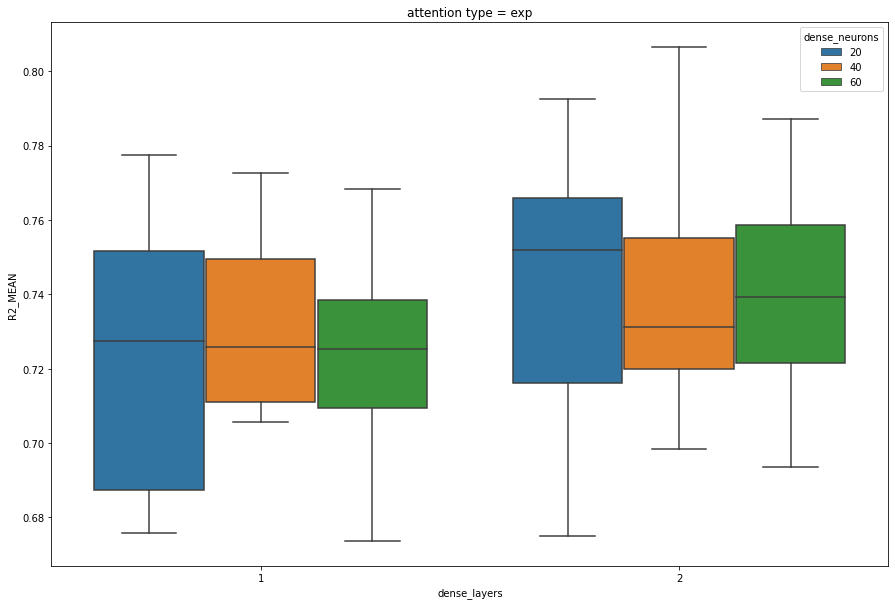

<Figure size 432x288 with 0 Axes>

In [14]:
data = result_reshape

plot_var = ['R2_MEAN']

print("R2 results")
plt.figure(figsize=(15*len(plot_var), 10))
for i, var in enumerate(plot_var):
    plt.subplot(len(plot_var), 1, i+1)
    plot_data = data[data['step']=='mean']
    sns.boxplot(x='dense_layers', y=var, hue='dense_neurons', data=plot_data, notch=False, showfliers = False)
    # plt.ylim(-0.01, 0.3)
    plt.title(f"attention type = {att_type}")
    
figure_name = f'dense_layer_neuron_comparison_future_{future_size}_DA_seq2seq_r2'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()

## Figure 2

R2 results


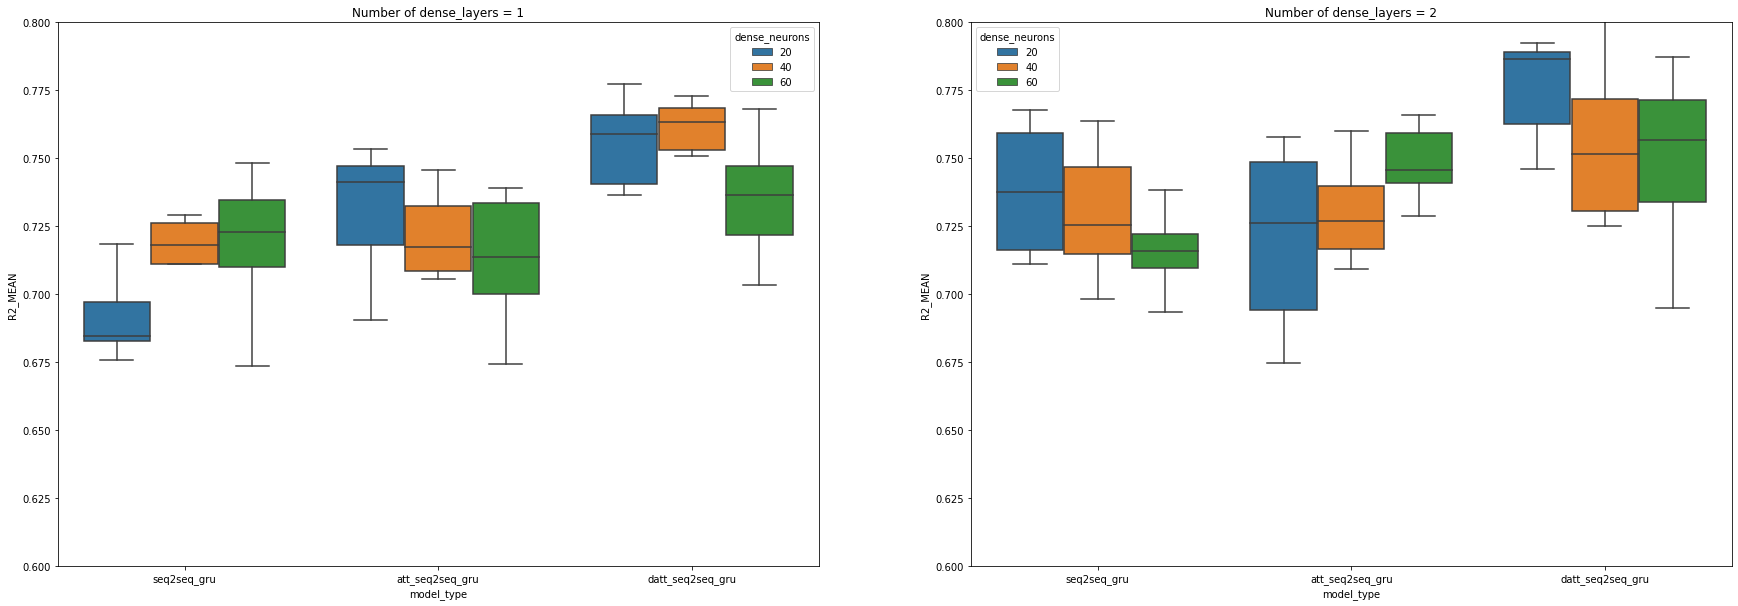

<Figure size 432x288 with 0 Axes>

In [15]:
data = result_reshape

plot_var = [1, 2]

print("R2 results")
plt.figure(figsize=(15*len(plot_var), 10))
for i, dense_layers in enumerate(plot_var):
    plt.subplot(1, len(plot_var), i+1)
    plot_data = data[(data['step']=='mean') & (data['dense_layers']==dense_layers)]
    sns.boxplot(x='model_type', y='R2_MEAN', hue='dense_neurons', data=plot_data, notch=False, showfliers = False)
    plt.ylim(0.6, 0.8)
    plt.title(f"Number of dense_layers = {dense_layers}")
    
figure_name = f'dense_layer_neuron_model_comparison_future_{future_size}_r2'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()